 ### Collaborative Filtering
 
We will be using movie lens dataset for trying out how collaborative filtering works. We will be using mulitple approaces

1. *User user filtering approach*
    - User user filtering aims to find similar users on the basis of their ratings/clicks/views to a particualr item or content
    - We can chose to reduce user bias towards ratings (recommended)

In [1]:
import pandas as pd
import numpy as np

In [2]:
# reading movie lens dataset

df = pd.read_csv(r'../rating.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    object
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [3]:
# converting int ids to strings to avoid any errors/miscalculations

df = df.drop('timestamp',axis = 1)
number_of_ratings  = df.shape[0]

In [4]:
df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [5]:
print(f'Unique users : {df.userId.nunique()} and unique movies : {df.movieId.nunique()}')

Unique users : 138493 and unique movies : 26744


Computing a 138K X 138K similarity matrix for user over 27K dimensional vector may prove to be computationally expensive, hence we will try to reduce the dataset and its sparsity by taking top users and movies

In [6]:
# Calculating cumulative percentages of ratings received at user level

userId_rating_count = df.userId.value_counts().reset_index().rename(columns = {'index':'UserId','userId':'Cnt_Movies_Rated'}).sort_values(by = 'Cnt_Movies_Rated',ascending = False)
userId_rating_count['Cumulative_Perc'] = userId_rating_count.Cnt_Movies_Rated.cumsum()/number_of_ratings

userids_at_80 = userId_rating_count.loc[userId_rating_count['Cumulative_Perc'] <= 0.4,'UserId']
print(f'Number of users who have given 40% of the total ratings : {len(userids_at_80)} and is {round(len(userids_at_80)*100/df.userId.nunique(),2)}% of total user base')

Number of users who have given 40% of the total ratings : 10691 and is 7.72% of total user base


In [7]:
# Calculating cumulative percentages of ratings received at movie level

movieId_rating_count = df.movieId.value_counts().reset_index().rename(columns = {'index':'MovieId','movieId':'Cnt_Users_Rated'}).sort_values(by = 'Cnt_Users_Rated',ascending = False)
movieId_rating_count['Cumulative_Perc'] = movieId_rating_count.Cnt_Users_Rated.cumsum()/number_of_ratings

movieids_at_80 = movieId_rating_count.loc[movieId_rating_count['Cumulative_Perc'] <= 0.80,'MovieId']
print(f'Number of movies which received 80% of the total ratings : {len(movieids_at_80)} and is {round(len(movieids_at_80)*100/df.movieId.nunique(),2)}% of total movie base')

Number of movies which received 80% of the total ratings : 1948 and is 7.28% of total movie base


In [8]:
# subsetting dataset for selected userids and movieids

df = df.loc[(df['userId'].isin(userids_at_80)) & (df['movieId'].isin(movieids_at_80))]
print(f'Number of ratings after using top 80% users and movies : {df.shape[0]/number_of_ratings * 100 :.2f}%')

Number of ratings after using top 80% users and movies : 27.85%


In [9]:
# dividing data to train test
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [10]:
avg_ratings_train = train.groupby('userId')['rating'].mean().reset_index().rename(columns = {'userId':'userId','rating':'avg_rating'})
avg_ratings_test = test.groupby('userId')['rating'].mean().reset_index().rename(columns = {'userId':'userId','rating':'avg_rating'})

train = pd.merge(train,avg_ratings_train, on = 'userId', how = 'left')
train['avg_rating'] = train.avg_rating.round(5)
train['Deviations'] = train['rating'] - train['avg_rating']

test = pd.merge(test,avg_ratings_test, on = 'userId', how = 'left')
test['avg_rating'] = test.avg_rating.round(5)
test['Deviations'] = test['rating'] - test['avg_rating']

train.head()

,userId,movieId,rating,avg_rating,Deviations
0,67947,2858,4.5,3.54114,0.95886
1,21215,2683,3.5,3.78342,-0.28342
2,97932,628,4.0,3.32903,0.67097
3,97738,3173,2.5,3.47097,-0.97097
4,71992,67255,4.0,3.70998,0.29002


In [11]:
avg_ratings_train = train[['userId','avg_rating']].drop_duplicates()
avg_ratings_test = test[['userId','avg_rating']].drop_duplicates()

#### We can use correlation matrix calculation over the total data set but it may seem unnecessary due to space complexity 

* Using a minimum 20 movies in common between 2 users to calculate their correlation
* A minimum of 25 nearest neighbours to be considered for predictions

In [14]:
import time

t = time.process_time()

min_movie_cnt = 20
nn = 50
user_nn_weights = {}
counter = 0

train_id_len = len(train.userId.unique())

for i in train.userId.unique():
    
    movie_i = set(train[train.userId==i]['movieId'].values)
    useri_movie = train[train.movieId.isin(movie_i)]
    users = useri_movie.userId.value_counts().to_frame().query('userId > @min_movie_cnt').index
    useri_movie = useri_movie.loc[(train.userId.isin(users))]
    useri_movie_pivot = useri_movie.pivot(index = 'movieId', columns = 'userId', values = 'rating')
    
    corr_useri_j = useri_movie_pivot.drop(i,axis = 1).apply(lambda x: round(x.corr(useri_movie_pivot[i]),5)).reset_index().rename(columns={'userId':'userId_j',0:'Corr'})
    corr_useri_j['ab_corr'] = abs(corr_useri_j['Corr'])
    corr_useri_j = corr_useri_j.sort_values(by = 'ab_corr',ascending = False).head(nn)
    
    user_nn_weights[i] = tuple(zip(corr_useri_j.userId_j,corr_useri_j.Corr))
    counter += 1
    if counter%1000 == 0:
        print(f'Completed {counter*100/train_id_len:.2f}%')

Completed 9.35%
Completed 18.71%
Completed 28.06%
Completed 37.41%
Completed 46.77%
Completed 56.12%
Completed 65.48%
Completed 74.83%
Completed 84.18%
Completed 93.54%


In [15]:
elapsed_time = time.process_time() - t
elapsed_time

54483.453125

In [16]:
import pickle
with open('user_nn_weights_10691_50nn.json', 'wb') as f:
  pickle.dump(user_nn_weights, f)

In [ ]:
#rating_dict_train = train[['userId','movieId','rating']].to_dict()

In [17]:
#len(movie_user_index_train), len(train1.movieId.unique())

from timeit import timeit
%timeit train.index[train.movieId==1307]


8.28 ms ± 618 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
train1 = train.copy()
train1.movieId = train1.movieId.astype('category')
train1.userId = train1.userId.astype('category')

from timeit import timeit
%timeit train1.index[train1.movieId=="001307"]

22.6 ms ± 586 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Multiple subsets of datasets will be faster if the id's are *integers*, if they were in *object* type then cpnversion to *category* type would be beneficial

In [19]:
movie_user_index_train = {}

for i in train.movieId.unique():
    movie_user_index_train[i] = train.index[train.movieId==i]


In [20]:
movie_user_index_test = {}

for i in test.movieId.unique():
    movie_user_index_test[i] = test.index[test.movieId==i]

In [21]:
len(movie_user_index_test), len(test.movieId.unique())

(1948, 1948)

In [22]:
def predict_rating(i,m,data,movie_user_index, weights, nn,avg_ratings):
    nn_weights = {}
    for u,c in weights[i]:
        nn_weights[u] = c

    nn_weights = pd.DataFrame.from_dict(nn_weights,orient = 'index',columns = ['weight']).reset_index().rename(columns = {'index':'userId','weight':'weight'})
    nn_weights = nn_weights.head(nn)
    #uj_m = data.loc[data.movieId==m]
    uj_m = data.loc[movie_user_index[m]]
    uj_m = pd.merge(uj_m, nn_weights, on = 'userId', how = 'inner')

    ####nn_uj_m = set(nn_m) & set(uj_m)

    useri_avg_rating = avg_ratings[avg_ratings.userId==i]['avg_rating'].values
    if len(uj_m):
        prediction = useri_avg_rating + sum(uj_m.Deviations * uj_m.weight)/abs(uj_m.weight).sum()
    else:
        prediction = useri_avg_rating
    
    return(prediction[0],len(uj_m))
    #return(uj_m)

In [23]:
from IPython.display import clear_output
start = time.process_time()

train_mse = {}

for j in range(20,55,5):
    counter = 0
    pred_train = []
    nn_used_for_prediction = []
    for i, m in list(zip(train.userId,train.movieId)):
        p, n = predict_rating(i,m,train,movie_user_index_train,user_nn_weights,j,avg_ratings_train)
        pred_train.append(p)
        nn_used_for_prediction.append(n)
        counter += 1
        if counter%1000000==0:
            print(f'Completed {counter*100/len(train1):.2f}%')
    
    
    train['Predictions'] = pred_train
    train['nn'] = nn_used_for_prediction
    mse = ((train.rating - train.Predictions)**2).mean()
    train_mse[j] = mse
    print(f'Completed training mse for {j} neighbours')

time.process_time() - start

Completed 22.45%
Completed 44.89%
Completed 67.34%
Completed 89.78%
Completed training mse for 20 neighbours
Completed 22.45%
Completed 44.89%
Completed 67.34%
Completed 89.78%
Completed training mse for 25 neighbours
Completed 22.45%
Completed 44.89%
Completed 67.34%
Completed 89.78%
Completed training mse for 30 neighbours
Completed 22.45%
Completed 44.89%
Completed 67.34%
Completed 89.78%
Completed training mse for 35 neighbours
Completed 22.45%
Completed 44.89%
Completed 67.34%
Completed 89.78%
Completed training mse for 40 neighbours
Completed 22.45%
Completed 44.89%
Completed 67.34%
Completed 89.78%
Completed training mse for 45 neighbours
Completed 22.45%
Completed 44.89%
Completed 67.34%
Completed 89.78%
Completed training mse for 50 neighbours


172571.171875

In [24]:
len(pred_train), train.shape[0]

(4455283, 4455283)

In [25]:
from IPython.display import clear_output
start = time.process_time()

test_mse = {}

for j in range(20,55,5):
    counter = 0
    pred_test = []
    nn_used_for_prediction = []
    for i, m in list(zip(test.userId,test.movieId)):
        p, n = predict_rating(i,m,test,movie_user_index_test,user_nn_weights,j,avg_ratings_test)
        pred_test.append(p)
        nn_used_for_prediction.append(n)
        counter += 1
        if counter%1000000==0:
            print(f'Completed {counter*100/len(train1):.2f}%')
    
    
    test['Predictions'] = pred_test
    test['nn'] = nn_used_for_prediction
    mse = ((test.rating - test.Predictions)**2).mean()
    test_mse[j] = mse
    print(f'Completed test mse for {j} neighbours')

time.process_time() - start

Completed 22.45%
Completed test mse for 20 neighbours
Completed 22.45%
Completed test mse for 25 neighbours
Completed 22.45%
Completed test mse for 30 neighbours
Completed 22.45%
Completed test mse for 35 neighbours
Completed 22.45%
Completed test mse for 40 neighbours
Completed 22.45%
Completed test mse for 45 neighbours
Completed 22.45%
Completed test mse for 50 neighbours


38790.375

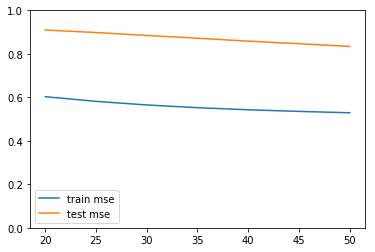

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = list(range(20,55,5))
plt.plot(x,train_mse.values(), label='train mse')
plt.plot(x,test_mse.values(), label='test mse')
plt.ylim([0, 1])
#plt.xticks(x, labels, rotation ='vertical')
plt.legend()
plt.show()

In [53]:
np.sqrt(train_mse[50]),np.sqrt(test_mse[50])

(0.7273524471653608, 0.913269187648182)

Close to the benchmarks of [0.83 - 0.86]

In [41]:
train['se'] = abs(train.rating - train.Predictions)
test['se'] = abs(test.rating - test.Predictions)

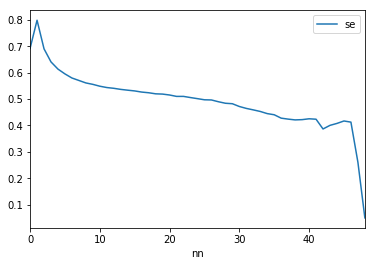

In [48]:
train.groupby('nn').agg({'se':'mean'}).plot()

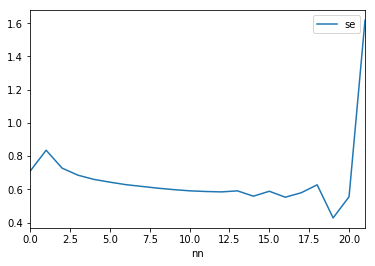

In [49]:
test.groupby('nn').agg({'se':'mean'}).plot()

The mse tends to be decrease with increase in number of neighbours which are used for predictions, to make sure that we get a good number of neighbours in majority cases we can decrease the minimum number of common movies needed criteria.